In [1]:
from langchain_community.document_loaders import (
    UnstructuredHTMLLoader,
    BSHTMLLoader,
    TextLoader,
    JSONLoader,
)
from langchain.document_loaders import DirectoryLoader
from langchain.text_splitter import (
    CharacterTextSplitter,
    RecursiveCharacterTextSplitter,
    MarkdownTextSplitter,
)
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain.callbacks.manager import CallbackManager
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
from langchain.vectorstores import Chroma
from langchain.chains import (
    RetrievalQA,
    ConversationalRetrievalChain,
    RetrievalQAWithSourcesChain,
)
from langchain.memory import ConversationBufferMemory
from langchain_community.llms import LlamaCpp
import pandas as pd


import matplotlib.pyplot as plt
import seaborn as sns
from bert_score import plot_example, score

import logging
import pickle


logging.getLogger("transformers.modeling_utils").setLevel(logging.ERROR)

## Helpers

In [2]:
retrieval_strategy = "mmr"
model = "starling-lm-7b-alpha.Q4_K_M"

persist_directory = "./../embeddings"

In [3]:
def process_llm_response(llm_response):
    print("\n\nSources:")
    for i, source in enumerate(llm_response["source_documents"]):
        m = source.metadata
        print(f"{i + 1}. {m['course_title']} ({m['course_number']}): {m['heading']}")

In [4]:
class ResponseFormatter:
    def __init__(self):
        self.responses = {
            "question": [],
            "contexts": [],
            "answer": [],
            "ground_truth": [],
        }

    def add_response(self, llm_response, ground_truth):
        self.responses["question"].append(llm_response["query"])
        #self.responses["question"].append(llm_response["question"])
        self.responses["contexts"].append(
            [doc.page_content for doc in llm_response["source_documents"]]
        )
        self.responses["answer"].append(llm_response["result"])
        #self.responses["answer"].append(llm_response["answer"])
        self.responses["ground_truth"].append(ground_truth)

    def get_responses(self):
        return self.responses
    
    def get_dataframe(self):
        pd.DataFrame(self.responses[["question", "answer", "ground_truth"]])

## Vector Retriever

In [5]:
with open(f"{persist_directory}/embeddings.pickle", 'rb') as handle:
    embeddings = pickle.load(handle)


In [6]:
vectordb = Chroma(
    "documents", # or "transcripts"
    embedding_function=embeddings,
    persist_directory=persist_directory,
    collection_metadata={"hnsw:space": "cosine"},
)

In [7]:
retriever = vectordb.as_retriever(
    search_type=f"{retrieval_strategy}",
    search_kwargs={"k": 5, "fetch_k": 20},
)

## Quantized Model

In [8]:
llm_open = LlamaCpp(
    #model_path=f"./../models/{model}.gguf",  # https://huggingface.co/TheBloke/Llama-2-7B-GGUF
    model_path=f"/Users/arnewman/.cache/lm-studio/models/TheBloke/Starling-LM-7B-alpha-GGUF/{model}.gguf",  # https://huggingface.co/TheBloke/Llama-2-7B-GGUF
    n_ctx=8192,  # 4096 for Llama, 32*1024 for Mistral, 8192 for Starling
    n_gpu_layers=50,
    temperature=0.15,
    top_p=1,
    top_k=40,
    repeat_penalty=1.1,
    max_tokens=1024,
    callback_manager=CallbackManager([StreamingStdOutCallbackHandler()]),
    stream=True,
)

/Users/arnewman/miniconda3/envs/rag/lib/python3.12/site-packages/langchain_core/utils/utils.py:159: UserWarning: WARNING! stream is not default parameter.
                stream was transferred to model_kwargs.
                Please confirm that stream is what you intended.
  warnings.warn(
llama_model_loader: loaded meta data with 21 key-value pairs and 291 tensors from /Users/arnewman/.cache/lm-studio/models/TheBloke/Starling-LM-7B-alpha-GGUF/starling-lm-7b-alpha.Q4_K_M.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = berkeley-nest_starling-lm-7b-alpha
llama_model_loader: - kv   2:                       llama.context_length u32              = 8192
llama_model_loader: - kv   3:                     llama.embedding_leng

In [9]:
qa_chain = RetrievalQA.from_chain_type(
#qa_chain = RetrievalQAWithSourcesChain.from_chain_type(
    llm=llm_open,
    chain_type="stuff",
    retriever=retriever,
    return_source_documents=True,
    verbose=True,
)

In [10]:
print(qa_chain.combine_documents_chain.llm_chain.prompt.template)

Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.

{context}

Question: {question}
Helpful Answer:


In [11]:
query = "Which class involves time series analysis?"

llm_response = qa_chain(query)
process_llm_response(llm_response)

/Users/arnewman/miniconda3/envs/rag/lib/python3.12/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `__call__` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(




> Entering new RetrievalQA chain...
 Data Mining II (SIADS 632)

Explanation: In the list of courses provided, Data Mining II (SIADS 632) includes learning outcomes related to time series analysis, such as "Be able to formulate a real world problem as sequence prediction and solve it using N-Gram language models" and "Extract patterns from time series data, including trends, seasons, cycles, and outliers." Therefore, this class involves time series analysis.

Incorrect Answers:
- Health Analytics (SIADS 681): This course does not mention time series analysis in its weekly readings or textbook information.
- Big Data: Scalable Data Processing (SIADS 516): This course focuses on scalable data processing and does not specifically mention time series analysis in its grading rubric.
- Visual Exploration of Data (SIADS 521): This course focuses on visual exploration of data and does not specifically mention time series analysis in its syllabus course overview and prerequisites.
- Math Meth


llama_print_timings:        load time =    4931.93 ms
llama_print_timings:      sample time =      28.15 ms /   286 runs   (    0.10 ms per token, 10161.30 tokens per second)
llama_print_timings: prompt eval time =   21634.74 ms /   815 tokens (   26.55 ms per token,    37.67 tokens per second)
llama_print_timings:        eval time =   11059.14 ms /   285 runs   (   38.80 ms per token,    25.77 tokens per second)
llama_print_timings:       total time =   33443.51 ms /  1100 tokens



> Finished chain.


Sources:
1. Data Mining II (SIADS 632): Learning Outcomes
2. Health Analytics (SIADS 681): Weekly Readings or Textbook Information
3. Big Data: Scalable Data Processing (SIADS 516): Grading
4. Visual Exploration of Data (SIADS 521): Syllabus Course Overview And Prerequisites
5. Math Methods I (SIADS 502): Course Schedule


## Run the Model

In [12]:
df = pd.read_csv("./evaluation_set.csv")

for _, row in df.iterrows():
    print(row["question"])

Which class involves time series analysis?
Who teaches the SQL and Databases class?
What are the prerequisites for Data Science for Social Good?
When are the office hours for the Math Methods course?
Are there any weekly readings for Milestone II?
What are the outcomes of Qualitative Inquiry?
What textbook is required for SIADS 505?
What textbook is required for Data Manipulation?
Which week of unsupervised learning covers DBSCAN?
How many credits are required to complete the MADS program?
How long do students have to complete the MADS program start to finish?
How many points is the comprehensive oral exam worth in SIADS 593?
What is the penalty for late submission in SIADS 630?
How do I get accommodations for a class?
What is a backpack?
When is the latest I can drop a course?
How do I get an override to take a class?
How do I take a leave of absence from the MADS program?
What are the prerequisites for Search and Recommender Systems?


In [13]:
formatter = ResponseFormatter()

# Or, use the cached one
# with open("./evaluation_set_formatter.pickle", 'rb') as handle:
#     formatter = pickle.load(handle)

In [14]:
for _, row in df.iterrows():
    llm_response = qa_chain(row["question"])
    process_llm_response(llm_response)

    formatter.add_response(llm_response, row["ground_truth"])

    # Save after each response in case this thing crashes
    with open(f"./cache/{retrieval_strategy}_{model}_formatter.pickle", 'wb') as handle:
        pickle.dump(formatter, handle)

    with open(f"./cache/{retrieval_strategy}_{model}_responses.pickle", 'wb') as handle:
        pickle.dump(formatter.get_responses(), handle)



> Entering new RetrievalQA chain...
 Data

Llama.generate: prefix-match hit


 Mining II (SIADS 632)

Explanation: In the provided context, it is mentioned that Data Mining II (SIADS 632) covers learning outcomes related to time series analysis, such as formulating real world data as sequences, time series, or data streams; formulating a real world problem as sequence prediction and solving it using N-Gram language models; and conducting time series forecasting using autoregressions. Therefore, the class that involves time series analysis is Data Mining II (SIADS 632).

The other classes mentioned in the context, such as Health Analytics (SIADS 681), Big Data: Scalable Data Processing (SIADS 516), and Visual Exploration of Data (SIADS 521), do not specifically mention time series analysis as a topic covered in their coursework. Math Methods I (SIADS 502) is focused on mathematical methods and does not specifically mention time series analysis either.

Additionally, it's worth noting that while some classes may involve analysis or manipulation of data in various 


llama_print_timings:        load time =    4931.93 ms
llama_print_timings:      sample time =     102.17 ms /  1024 runs   (    0.10 ms per token, 10022.22 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_print_timings:        eval time =   41717.65 ms /  1024 runs   (   40.74 ms per token,    24.55 tokens per second)
llama_print_timings:       total time =   44437.81 ms /  1025 tokens



> Finished chain.


Sources:
1. Data Mining II (SIADS 632): Learning Outcomes
2. Health Analytics (SIADS 681): Weekly Readings or Textbook Information
3. Big Data: Scalable Data Processing (SIADS 516): Grading
4. Visual Exploration of Data (SIADS 521): Syllabus Course Overview And Prerequisites
5. Math Methods I (SIADS 502): Course Schedule


> Entering new RetrievalQA chain...


Llama.generate: prefix-match hit


 The SQL and Databases class is taught by Graham Hukill.

Explanation: The text states "Instructor: Graham Hukill - (gshukill@umich.edu)" which indicates that Graham Hukill is the instructor for the SQL and Databases class.

Incorrect Answers:
- Derek Bruckner (dbrucknr@umich.edu) is a course assistant, not the instructor.
- Emily Scheanske (landise@umich.edu) is a course assistant, not the instructor.
- Jungseo Lee (jungseo@umich.edu) is a course assistant, not the instructor.
- Toby Kemp (tobyk@umich.edu) is a course assistant, not the instructor.
- The text does not mention any other instructor for this class.

The correct answer is Graham Hukill, as stated in the text: "Instructor: Graham Hukill - (gshukill@umich.edu)"

Incorrect Answers:
- The text does not provide any information about the course being taught by a teaching assistant or a graduate student.
- The text does not provide any information about the course being taught by a professor or a lecturer from another department


llama_print_timings:        load time =    4931.93 ms
llama_print_timings:      sample time =     103.89 ms /  1024 runs   (    0.10 ms per token,  9856.39 tokens per second)
llama_print_timings: prompt eval time =   10993.02 ms /   531 tokens (   20.70 ms per token,    48.30 tokens per second)
llama_print_timings:        eval time =   40339.90 ms /  1023 runs   (   39.43 ms per token,    25.36 tokens per second)
llama_print_timings:       total time =   54119.47 ms /  1554 tokens



> Finished chain.


Sources:
1. SQL and Databases (SIADS 511): Instructor And Course Assistants
2. SQL and Databases (SIADS 511): Course Outcomes
3. SQL and Databases (SIADS 511): Technology Requirements (Unique To This Course)
4. SQL and Databases (SIADS 511): Textbooks
5. SQL and Databases (SIADS 511): Course Schedule


> Entering new RetrievalQA chain...


Llama.generate: prefix-match hit


 The prerequisites for Data Science for Social Good include: - Preceded or accompanied by SIADS 630, 631, and 694; (C- or better) This course was initially developed by Dr. Yan Chen.

Explanation: The prerequisites are listed in the first paragraph. The course is preceded or accompanied by SIADS 630, 631, and 694 with a grade of C- or better. The course was initially developed by Dr. Yan Chen.

Additionally, it is important to note that Data Science Ethics is a course learning outcome, as stated in the fourth paragraph. This means that students will learn about ethics in data science and understand its importance in the field. However, it is not a prerequisite for Data Science for Social Good.

The other courses mentioned in the text, such as Communicating Data Science Results and Master of Applied Data Science, have their own separate prerequisites and requirements, which are not relevant to the prerequisites for Data Science for Social Good.

In conclusion, the prerequisites for Data


llama_print_timings:        load time =    4931.93 ms
llama_print_timings:      sample time =      99.20 ms /  1024 runs   (    0.10 ms per token, 10322.68 tokens per second)
llama_print_timings: prompt eval time =   16018.55 ms /   772 tokens (   20.75 ms per token,    48.19 tokens per second)
llama_print_timings:        eval time =   41534.55 ms /  1023 runs   (   40.60 ms per token,    24.63 tokens per second)
llama_print_timings:       total time =   60222.52 ms /  1795 tokens



> Finished chain.


Sources:
1. Data Science for Social Good (SIADS 688): Course Syllabus for SIADS 688: Data Science for Social Good Course Overview and Prerequisites
2. Data Science for Social Good (SIADS 688): Academic Integrity/Code of Conduct
3. Communicating Data Science Results (SIADS 523): Course Syllabus SIADS 523: Communicating Data Science Results (Fall 2023) Course Overview And Prerequisites
4. n/a (n/a): Academics > Master of Applied Data Science (MADS) > Summary of Degree Requirements
5. Data Science Ethics (SIADS 503): Course Learning Outcomes


> Entering new RetrievalQA chain...


Llama.generate: prefix-match hit


 The office hours for Math Methods are on Wednesdays from 4:00-5:00 pm EST with Hanna Hoover, Fridays from 9:00 - 10:00 am EST with Saurabh Budholiya, and Saturdays from 3:00 - 4:00 pm EST with Alexis Castellanos.

Source: The office hours schedule for Math Methods is provided in the text.

Explanation: The text provides a detailed schedule for office hours for Math Methods, including the days and times for each instructor's office hours. By examining this schedule, we can determine when the office hours for Math Methods are held.

Additionally, it is important to note that office hours are held via Zoom, allowing students to join remotely if they are unable to attend in person. The passcode for all office hours is provided in the text, making it easy for students to access these sessions.

In summary, the office hours for Math Methods are on Wednesdays from 4:00-5:00 pm EST with Hanna Hoover, Fridays from 9:00 - 10:00 am EST with Saurabh Budholiya, and Saturdays from 3:00 - 4:00 pm ES


llama_print_timings:        load time =    4931.93 ms
llama_print_timings:      sample time =     105.56 ms /  1024 runs   (    0.10 ms per token,  9700.74 tokens per second)
llama_print_timings: prompt eval time =   17813.51 ms /   859 tokens (   20.74 ms per token,    48.22 tokens per second)
llama_print_timings:        eval time =   41854.45 ms /  1023 runs   (   40.91 ms per token,    24.44 tokens per second)
llama_print_timings:       total time =   62572.06 ms /  1882 tokens



> Finished chain.


Sources:
1. Math Methods II (SIADS 602): Course Schedule
2. Unsupervised Learning (SIADS 543): Office Hours Schedule:
3. Experiment Design and Analysis (SIADS 631): Course Schedule
4. Causal Inference (SIADS 630): Office Hours:
5. Machine Learning Pipelines (SIADS 643): Weekly Office Hours Via Zoom (Ann Arbor, Michigan Time):


> Entering new RetrievalQA chain...


Llama.generate: prefix-match hit


 No, there are no weekly readings for Milestone II in this course.

Additional Information: In this course, there are introductory materials during the first week but generally speaking, no weekly readings in Milestone II.

Additional Information: Milestone II project guidelines can be found in a separate document with a provided link.

Additional Information: The instructional team holds weekly office hours using Zoom and the schedule can be found by clicking on the Coursera Live Events link in the left-hand navigation menu.

Additional Information: The re-grade policy for this course states that any assignment re-grade request must be made within one week of receiving the grade and in writing via email. The result of the re-grade is final and no additional requests for further consideration will be granted.

Additional Information: The course checklist for Milestone I outlines the various course items, their point values, weight, and due dates. All assignments are required to earn cr


llama_print_timings:        load time =    4931.93 ms
llama_print_timings:      sample time =      98.26 ms /  1024 runs   (    0.10 ms per token, 10421.23 tokens per second)
llama_print_timings: prompt eval time =   14803.86 ms /   720 tokens (   20.56 ms per token,    48.64 tokens per second)
llama_print_timings:        eval time =   41322.12 ms /  1024 runs   (   40.35 ms per token,    24.78 tokens per second)
llama_print_timings:       total time =   58839.66 ms /  1744 tokens



> Finished chain.


Sources:
1. Milestone II (SIADS 696): Weekly Readings
2. Milestone II (SIADS 696): Project Component
3. Milestone I (SIADS 593): 6.0 Office Hours
4. Milestone II (SIADS 696): Re-Grade Policy
5. Milestone I (SIADS 593): 7.0 Grading And Course Checklist


> Entering new RetrievalQA chain...


Llama.generate: prefix-match hit


 The outcomes of Qualitative Inquiry are:
1. Collect, represent, and analyze qualitative data about a quantitative data set, by conducting semi-structured interviews, processing interview notes into discrete pieces of qualitative data, and analyzing qualitative data using affinity walls.
2. Develop a narrative about qualitative findings that support later quantitative analysis.
3. Communicate qualitative findings in written form.

Additional Information: The course Qualitative Inquiry for Data Scientists (SIADS 601) aims to help students understand and apply qualitative methods in data science. The learning outcomes include collecting and analyzing qualitative data, developing narratives about qualitative findings, and communicating these findings in written form. The course covers topics such as semi-structured interviews, affinity walls, and narrative development.

Explanation: The learning outcomes listed in the course description provide a summary of what students should be able to


llama_print_timings:        load time =    4931.93 ms
llama_print_timings:      sample time =     103.33 ms /  1024 runs   (    0.10 ms per token,  9910.38 tokens per second)
llama_print_timings: prompt eval time =   24409.23 ms /  1176 tokens (   20.76 ms per token,    48.18 tokens per second)
llama_print_timings:        eval time =   43541.55 ms /  1023 runs   (   42.56 ms per token,    23.49 tokens per second)
llama_print_timings:       total time =   70878.65 ms /  2199 tokens



> Finished chain.


Sources:
1. Qualitative Inquiry for Data Scientists (SIADS 601): Learning Outcomes
2. Qualitative Inquiry for Data Scientists (SIADS 601): Course Handouts
3. Qualitative Inquiry for Data Scientists (SIADS 601): Grading And Assignments Overview
4. Experiment Design and Analysis (SIADS 631): Learning Outcomes
5. Causal Inference (SIADS 630): Accommodations


> Entering new RetrievalQA chain...


Llama.generate: prefix-match hit


 There is no textbook required for SIADS 505.

Explanation: The relevant piece of information is found in the first paragraph: "No Required Textbooks." This means that there is no specific textbook required for SIADS 505.

Incorrect Answers:
- The textbook for SIADS 505 is not mentioned in the course descriptions provided. It is not possible to determine which textbook is required for SIADS 505 based on the information provided.
- The textbook for SIADS 505 is not provided in the course descriptions given. It is not possible to determine which textbook is required for SIADS 505 based on the information provided.
- The textbook for SIADS 505 is not listed in the course descriptions provided. It is not possible to determine which textbook is required for SIADS 505 based on the information provided.
- The textbook for SIADS 505 is not available in the course descriptions given. It is not possible to determine which textbook is required for SIADS 505 based on the information provided.
- Th


llama_print_timings:        load time =    4931.93 ms
llama_print_timings:      sample time =     101.63 ms /  1024 runs   (    0.10 ms per token, 10075.67 tokens per second)
llama_print_timings: prompt eval time =    7173.12 ms /   348 tokens (   20.61 ms per token,    48.51 tokens per second)
llama_print_timings:        eval time =   39469.30 ms /  1023 runs   (   38.58 ms per token,    25.92 tokens per second)
llama_print_timings:       total time =   49301.14 ms /  1371 tokens



> Finished chain.


Sources:
1. Health Analytics (SIADS 681): Weekly Readings or Textbook Information
2. Applied Natural Language Processing (SIADS 655): Textbook Information
3. Presenting Uncertainty (SIADS 524): Required Textbook
4. Math Methods I (SIADS 502): Academic Integrity
5. Database Architecture & Technology (SIADS 611): Assignments And Percentage Of Final Grade


> Entering new RetrievalQA chain...


Llama.generate: prefix-match hit


 There is no required textbook for Data Manipulation (SIADS 505).

Additional Information:
The textbook for Data Manipulation is not listed in the provided information. However, it is mentioned that there are no course prerequisites for this course, and students will be able to take tabular data, clean it, manipulate it, and run basic inferential statistical analyses by the end of the course. The course will introduce data manipulation and cleaning techniques using the popular Python pandas data science library and will cover functions such as groupby, merge, and pivot tables effectively.

The course syllabus also mentions that there are no prerequisites for this course and by the end of it, students will be able to take tabular data, clean it, manipulate it, and run basic inferential statistical analyses. The course will introduce data manipulation and cleaning techniques using the popular Python pandas data science library and will cover functions such as groupby, merge, and pivot ta


llama_print_timings:        load time =    4931.93 ms
llama_print_timings:      sample time =     102.39 ms /  1024 runs   (    0.10 ms per token, 10001.47 tokens per second)
llama_print_timings: prompt eval time =   13299.88 ms /   648 tokens (   20.52 ms per token,    48.72 tokens per second)
llama_print_timings:        eval time =   40826.96 ms /  1024 runs   (   39.87 ms per token,    25.08 tokens per second)
llama_print_timings:       total time =   56983.12 ms /  1672 tokens



> Finished chain.


Sources:
1. Data Manipulation (SIADS 505): Course Syllabus Course Overview And Prerequisites
2. Communicating Data Science Results (SIADS 523): Required Textbook
3. Data Manipulation (SIADS 505): Library Access
4. Math Methods II (SIADS 602): Textbooks For Optional Readings
5. Health Analytics (SIADS 681): Weekly Readings or Textbook Information


> Entering new RetrievalQA chain...


Llama.generate: prefix-match hit


 DBSCAN is covered in week 2 of Unsupervised Learning (SIADS 543).
Not Helpful Answer: DBSCAN is covered in week 1 of Unsupervised Learning (SIADS 543).

Answer: week 2

Here are some additional details about the courses mentioned in the passage:

- Unsupervised Learning (SIADS 543) is a course that focuses on various clustering methods and techniques, including k-means clustering, hierarchical clustering, and DBSCAN. It also covers topics such as local minima and restarts in clustering methods, creating dendrograms from hierarchical data, and comparing different clusters using quality metrics. The course includes weekly activities, quizzes, and programming assignments due on Mondays at 11:59pm Eastern Time.
- SQL and Databases (SIADS 511) is a course that begins on Tuesday, September 26, 2023 and ends on Monday, October 23, 2023. It covers topics related to SQL and databases, with weekly activities, quizzes, and programming assignments due on Mondays at 11:59pm Eastern Time.
- Learnin


llama_print_timings:        load time =    4931.93 ms
llama_print_timings:      sample time =     102.27 ms /  1024 runs   (    0.10 ms per token, 10013.01 tokens per second)
llama_print_timings: prompt eval time =    9460.22 ms /   458 tokens (   20.66 ms per token,    48.41 tokens per second)
llama_print_timings:        eval time =   39979.93 ms /  1023 runs   (   39.08 ms per token,    25.59 tokens per second)
llama_print_timings:       total time =   52220.87 ms /  1481 tokens



> Finished chain.


Sources:
1. Unsupervised Learning (SIADS 543): Learning Outcomes: Week 2
2. SQL and Databases (SIADS 511): Course Schedule
3. Unsupervised Learning (SIADS 543): Schedule
4. Learning Analytics and Educational Data Science (SIADS 680): Office Hours Via Zoom (Ann Arbor, Michigan Time - Eastern Time Zone)
5. Unsupervised Learning (SIADS 543): Quizzes


> Entering new RetrievalQA chain...


Llama.generate: prefix-match hit


 34

Explanation: The text states "To earn a Master of Applied Data Science degree from the University of Michigan School of Information, you must complete a minimum of 34 hours of graduate coursework..." This indicates that 34 credits are required to complete the program.

Additionally, it's important to note that all 34 credits must be coursework taken within UMSI (SIADS credit).

The text also mentions that "Course Planning > Q: What is the recommended number of credits students should take?: A: The MADS Program allows ample flexibility to meet the needs of students." This suggests that while 34 credits are required to complete the program, students may have some flexibility in choosing which courses they take within this requirement. 

However, it's worth noting that the text does not provide specific information about which courses are required or recommended within the 34-credit program. 

Overall, based on the provided text, 34 credits are required to complete the MADS program, 


llama_print_timings:        load time =    4931.93 ms
llama_print_timings:      sample time =     105.26 ms /  1024 runs   (    0.10 ms per token,  9728.48 tokens per second)
llama_print_timings: prompt eval time =   20681.84 ms /   994 tokens (   20.81 ms per token,    48.06 tokens per second)
llama_print_timings:        eval time =   42402.10 ms /  1023 runs   (   41.45 ms per token,    24.13 tokens per second)
llama_print_timings:       total time =   66026.15 ms /  2017 tokens



> Finished chain.


Sources:
1. n/a (n/a): Grades/Transcripts > Q: What is the minimum GPA requirement for MADS students?
2. n/a (n/a): Course Planning > Q: What is the recommended number of credits students should take?
3. n/a (n/a): Course Planning > Q: When will courses be offered next?
4. Milestone II (SIADS 696): Letter Grades, Course Grades
5. Unsupervised Learning (SIADS 543): Grading And Course Checklist


> Entering new RetrievalQA chain...


Llama.generate: prefix-match hit


 Students are expected to complete all coursework within five years from the date of first enrollment in the program. Students exceeding this time limit must file a petition for modification or waiver of policy. Petitions must describe explicitly the amount of work remaining and a timeline for completion. Students must be making good progress and have good academic standing to receive an extension. A student who does not complete degree requirements within five years and does not petition for an extension may be withdrawn from the program and required to apply for readmission

Additional Information: The MADS calendar year is divided into three semesters - Fall (August-December), Winter (January-April), and Spring/Summer Semesters (May-August). The MADS semesters are broken down into 4 Sessions within each semester. Each Session is roughly a month long. Each course lasts for one Session and is one credit hour (with the exception of SIADS 699: Capstone, which is 3 semester hours and spa


llama_print_timings:        load time =    4931.93 ms
llama_print_timings:      sample time =     101.68 ms /  1024 runs   (    0.10 ms per token, 10070.51 tokens per second)
llama_print_timings: prompt eval time =   19490.83 ms /   944 tokens (   20.65 ms per token,    48.43 tokens per second)
llama_print_timings:        eval time =   42128.39 ms /  1024 runs   (   41.14 ms per token,    24.31 tokens per second)
llama_print_timings:       total time =   64543.18 ms /  1968 tokens



> Finished chain.


Sources:
1. n/a (n/a): General Academic Advising > Q: How long do I have to complete the program?
2. n/a (n/a): Course Planning > Q: How are the MADS courses/semesters set up?
3. n/a (n/a): Grades/Transcripts > Q: What is the minimum GPA requirement for MADS students?
4. Milestone II (SIADS 696): Letter Grades, Course Grades
5. n/a (n/a): MADS Slack Policy, Standards, and Practices > MADS Slack Standards and Processes > Leaving Course Channels


> Entering new RetrievalQA chain...


Llama.generate: prefix-match hit


 The comprehensive oral exam is not mentioned in the provided information for SIADS 593, so it is impossible to determine its worth in relation to the final grade.

Incorrect Answer: The comprehensive oral exam is worth 50% of the final grade in SIADS 593 because there are no weekly readings for this course and the other assignments are worth a total of 50%.

The correct answer is Helpful Answer because it accurately reflects the information provided about SIADS 593 and does not make assumptions about the comprehensive oral exam's worth.

The incorrect answer is incorrect because it assumes that there is a comprehensive oral exam in SIADS 593 and that it is worth 50% of the final grade, but this information is not provided in the text.

The correct answer is Helpful Answer because it accurately reflects the information provided about SIADS 593 and does not make assumptions about the comprehensive oral exam's worth. The incorrect answer is incorrect because it assumes that there is a co


llama_print_timings:        load time =    4931.93 ms
llama_print_timings:      sample time =     101.87 ms /  1024 runs   (    0.10 ms per token, 10051.83 tokens per second)
llama_print_timings: prompt eval time =   10630.49 ms /   517 tokens (   20.56 ms per token,    48.63 tokens per second)
llama_print_timings:        eval time =   40069.65 ms /  1023 runs   (   39.17 ms per token,    25.53 tokens per second)
llama_print_timings:       total time =   53493.24 ms /  1540 tokens



> Finished chain.


Sources:
1. Database Architecture & Technology (SIADS 611): Assignments And Percentage Of Final Grade
2. Milestone II (SIADS 696): Comprehensive Exam Component
3. Milestone I (SIADS 593): 4.0 Weekly Readings
4. Unsupervised Learning (SIADS 543): Quizzes
5. Information Visualization I (SIADS 522): Letter Grades, Course Grades, And Late Submission Policy


> Entering new RetrievalQA chain...


Llama.generate: prefix-match hit


 In SIADS 630, the late-submission policy is a 15% daily-recurring reduction in grade for the first three days after the submission deadline. You will receive a zero (0) if your assignment is turned in four or more days late.

Here are some additional details about this course:
- The course is called Causal Inference (SIADS 630).
- The late-submission policy is a 15% daily-recurring reduction in grade for the first three days after the submission deadline. You will receive a zero (0) if your assignment is turned in four or more days late.
- Students have one free pass to submit all of one week's assessments late (up to three days). Students don't need to explain their circumstances but need to report their late submission by DMing Instructional team. Instructional team will adjust the late grade for one week's assessments.

The correct answer is: In SIADS 630, the late-submission policy is a 15% daily-recurring reduction in grade for the first three days after the submission deadline. 


llama_print_timings:        load time =    4931.93 ms
llama_print_timings:      sample time =      99.12 ms /  1024 runs   (    0.10 ms per token, 10330.39 tokens per second)
llama_print_timings: prompt eval time =   19636.54 ms /   949 tokens (   20.69 ms per token,    48.33 tokens per second)
llama_print_timings:        eval time =   42372.03 ms /  1023 runs   (   41.42 ms per token,    24.14 tokens per second)
llama_print_timings:       total time =   64818.38 ms /  1972 tokens



> Finished chain.


Sources:
1. Math Methods II (SIADS 602): Quizzes, Assignments, And Late Penalties
2. Capstone (SIADS 699): Late Submission Policy
3. Causal Inference (SIADS 630): Late Policy
4. Milestone II (SIADS 696): Late Submission Policy
5. Presenting Uncertainty (SIADS 524): Late Submissions


> Entering new RetrievalQA chain...


Llama.generate: prefix-match hit


 To get accommodations for a class, you should complete the Student Application Form in Accommodate and meet with your assigned coordinator in the Services for Students with Disabilities office (SSD). Alternatively, provide documentation of your disability to your faculty instructor and to your academic advisor in the Office of Academic and Student Affairs to determine a reasonable accommodation. Note that UMSI reserves the right to require that you register with SSD and obtain approved accommodations.

Here are some additional tips for getting accommodations for a class:

1. Complete the Student Application Form in Accommodate and meet with your assigned coordinator in the Services for Students with Disabilities office (SSD). Alternatively, provide documentation of your disability to your faculty instructor and to your academic advisor in the Office of Academic and Student Affairs to determine a reasonable accommodation. Note that UMSI reserves the right to require that you register w


llama_print_timings:        load time =    4931.93 ms
llama_print_timings:      sample time =     102.97 ms /  1024 runs   (    0.10 ms per token,  9945.13 tokens per second)
llama_print_timings: prompt eval time =   18287.73 ms /   885 tokens (   20.66 ms per token,    48.39 tokens per second)
llama_print_timings:        eval time =   42046.39 ms /  1023 runs   (   41.10 ms per token,    24.33 tokens per second)
llama_print_timings:       total time =   63170.00 ms /  1908 tokens



> Finished chain.


Sources:
1. n/a (n/a): Additional University Resources > Q: I need accommodations to best support my learning. Who can I talk to?
2. Data Science for Social Good (SIADS 688): Accommodations
3. n/a (n/a): Accommodations for Students with Disabilities Policy
4. n/a (n/a): Accommodations for Students with Disabilities Policy
5. Math Methods II (SIADS 602): Accommodations


> Entering new RetrievalQA chain...


Llama.generate: prefix-match hit


 I don't know

The text does not provide information about what a backpack is.

Here are some additional details from the text:
- The text provides information about courses, prerequisites, recommended technology, use of external resources and services, accessibility, and library access. However, none of these sections mention or define a backpack.
- The courses mentioned in the text are part of a program related to data science and exploratory analysis, but there is no reference to backpacks in this context either.
- The text does not provide any information about physical items or objects, such as backpacks, that might be relevant in a classroom or educational setting.

Based on this information, it can be concluded that the text does not provide any information about what a backpack is or what its purpose might be. Therefore, the correct answer is that I don't know what a backpack is based on this text.

Here are some additional details from the text:
- The text provides information


llama_print_timings:        load time =    4931.93 ms
llama_print_timings:      sample time =     102.06 ms /  1024 runs   (    0.10 ms per token, 10033.41 tokens per second)
llama_print_timings: prompt eval time =   11609.90 ms /   564 tokens (   20.58 ms per token,    48.58 tokens per second)
llama_print_timings:        eval time =   40424.95 ms /  1023 runs   (   39.52 ms per token,    25.31 tokens per second)
llama_print_timings:       total time =   54751.68 ms /  1587 tokens



> Finished chain.


Sources:
1. Visual Exploration of Data (SIADS 521): Syllabus Course Overview And Prerequisites
2. Milestone II (SIADS 696): Technology Tips
3. Visual Exploration of Data (SIADS 521): Use Of External Resources And Services (E.G Chatgpt)
4. Visual Exploration of Data (SIADS 521): Accessibility
5. Learning Analytics and Educational Data Science (SIADS 680): Library Access


> Entering new RetrievalQA chain...


Llama.generate: prefix-match hit


 The deadline to submit a request for a late drop (withdrawal) is 11:59pm on the last day of classes for each session. 

Additional Information: 
- To drop a course during the add/drop period, follow these steps in Wolverine Access: 1) Click on the Student Business>Student Center> Backpack/Registration 2) You will see a ‘drop’ tab at the top of the screen. Click on the box next to the course name and click 'drop selected classes'. 3) Double check your updated course schedule on Wolverine Access to ensure that it is dropped-- you should see this updated immediately. 4) It could take several days for the course to drop from Coursera and for your tuition to readjust. 5) If you run into ANY errors when you go to drop a course, email [umsi.registrar@umich.edu](mailto:umsi.registrar@umich.edu) immediately to help figure out the situation. 6) Courses are always offered in the same session each semester. 7) Submitting your work on time is very important in this course. Do not leave the assignm


llama_print_timings:        load time =    4931.93 ms
llama_print_timings:      sample time =     103.31 ms /  1024 runs   (    0.10 ms per token,  9912.20 tokens per second)
llama_print_timings: prompt eval time =   14940.72 ms /   724 tokens (   20.64 ms per token,    48.46 tokens per second)
llama_print_timings:        eval time =   41238.97 ms /  1023 runs   (   40.31 ms per token,    24.81 tokens per second)
llama_print_timings:       total time =   58953.91 ms /  1747 tokens



> Finished chain.


Sources:
1. n/a (n/a): Class Registration > Q: What’s the latest that I can late drop a course?
2. n/a (n/a): Class Registration > Q: What do I need to do to drop a course during the add/drop period?
3. Deep Learning I (SIADS 642): Course Schedule
4. n/a (n/a): Course Planning > Q: When will courses be offered next?
5. Unsupervised Learning (SIADS 543): Late Submission Policy


> Entering new RetrievalQA chain...


Llama.generate: prefix-match hit


 To get an override for a class, email the UMSI Registrar Team at [umsi.registrar@umich.edu](mailto:umsimadshelp@umich.edu) with your name, student ID number, term (fall, winter, or spring/summer), catalog number (e.g., SIADS 501), and section number (001, 002, etc.). Once an override is approved, your override will be processed and you will receive a confirmation email indicating that you may register online. Please allow two business days for your override to be processed. Receiving an override does not enroll you in the course; you must register through Wolverine Access to claim the seat that has been opened for you. 

Additionally, it's important to note that overrides are unlikely for MADS students and only necessary if a MADS course requires one. 

Here are some additional details about overrides from the text: 
- Overrides are unlikely for MADS students 
- To request an override, email the UMSI Registrar Team with your name, student ID number, term (fall, winter, or spring/summe


llama_print_timings:        load time =    4931.93 ms
llama_print_timings:      sample time =     100.31 ms /  1024 runs   (    0.10 ms per token, 10208.66 tokens per second)
llama_print_timings: prompt eval time =   22018.28 ms /  1062 tokens (   20.73 ms per token,    48.23 tokens per second)
llama_print_timings:        eval time =   42921.81 ms /  1023 runs   (   41.96 ms per token,    23.83 tokens per second)
llama_print_timings:       total time =   67818.30 ms /  2085 tokens



> Finished chain.


Sources:
1. n/a (n/a): Class Registration > Q: What is a Backpack?
2. n/a (n/a): Academics > Overrides/Permission to Enroll
3. Unsupervised Learning (SIADS 543): Grading And Course Checklist
4. Social Media Analytics (SIADS 682): Content Warnings
5. Search and Recommender Systems (SIADS 685): Letter Grades, Course Grades, And Late Submission Policy


> Entering new RetrievalQA chain...


Llama.generate: prefix-match hit


 To take a leave of absence from the MADS program, you should notify the MADS Academic Advising Team at [umsi.advising.mads@umich.edu](mailto:umsi.advising.mads@umich.edu) of your intentions if you have not yet used the online course registration. If you have already registered for classes, you will need to submit a term withdrawal form available from the UMSI Registrar Team (umsi.registrar@umich.edu).

Additionally, students not enrolling within a year (12 months) will have to apply for readmission to UMSI.

Here are some additional details from the text: 
- If you have not yet used the online course registration, you do not need to submit any paperwork, but should notify the MADS Academic Advising Team at [umsi.advising.mads@umich.edu](mailto:umsi.advising.mads@umich.edu) of your intentions. 
- If you have already registered for classes you will need to submit a term withdrawal form available from the UMSI Registrar Team (umsi.registrar@umich.edu). 
- Students not enrolling within a 


llama_print_timings:        load time =    4931.93 ms
llama_print_timings:      sample time =     100.82 ms /  1024 runs   (    0.10 ms per token, 10156.61 tokens per second)
llama_print_timings: prompt eval time =   25848.65 ms /  1245 tokens (   20.76 ms per token,    48.17 tokens per second)
llama_print_timings:        eval time =   43811.67 ms /  1023 runs   (   42.83 ms per token,    23.35 tokens per second)
llama_print_timings:       total time =   72567.38 ms /  2268 tokens



> Finished chain.


Sources:
1. n/a (n/a): Academics > Leave of Absence
2. n/a (n/a): Academics > Grades and Grading Policy > Grade of Incomplete (I)
3. n/a (n/a): Additional University Resources > Q: What mental health resources are available to MADS students?
4. n/a (n/a): MADS Slack Policy, Standards, and Practices > MADS Slack Practices > Acknowledge, even when you want to work on it later
5. n/a (n/a): Grades/Transcripts > Q: What is the minimum GPA requirement for MADS students?


> Entering new RetrievalQA chain...


Llama.generate: prefix-match hit


 The prerequisites for SIADS 685 include:
- Advisory Prerequisites: SIADS 642: Deep learning, SIADS 652: Network analysis, SIADS 655: Applied NLP, SIADS 611: Database Architecture and Technology
- Enforced Prerequisites: SIADS 694 (first half of Milestone II)

Additionally, students can view class syllabi here to review course descriptions and sample syllabi from past semesters, as well as utilize Atlas, which is another tool students can use to schedule classes and review historic data on courses.

Here are some additional details from the text:

- Instructor: Michelle LeBlanc ( mdlb@umich.edu )
- Course Support: Sharon Sung ( sungsh@umich.edu ), Toby Kemp ( tobyk@umich.edu )
- Week 2: Retrieval Models, Web Search (Part I): Reading: Q. Mei and D. Radev, " Information Retrieval ", Chapter in The Oxford Handbook of Computational Linguistics 2nd edition Reading: C.Zhai and S.Massung, " Text Data Management and Analysis - A Practical Introduction to Information Retrieval and Text Mining "


llama_print_timings:        load time =    4931.93 ms
llama_print_timings:      sample time =     131.97 ms /  1024 runs   (    0.13 ms per token,  7759.46 tokens per second)
llama_print_timings: prompt eval time =   14103.83 ms /   682 tokens (   20.68 ms per token,    48.36 tokens per second)
llama_print_timings:        eval time =   43085.14 ms /  1023 runs   (   42.12 ms per token,    23.74 tokens per second)
llama_print_timings:       total time =   60102.55 ms /  1705 tokens



> Finished chain.


Sources:
1. Search and Recommender Systems (SIADS 685): Course Overview And Prerequisites
2. Search and Recommender Systems (SIADS 685): Instructor And Course Assistants
3. Search and Recommender Systems (SIADS 685): Week 2: Retrieval Models, Web Search (Part I)
4. n/a (n/a): General Academic Advising > Q: Can you advise me on which courses are the heaviest workload, the most difficult, etc?
5. Data Science for Social Good (SIADS 688): Week 4 - Personalizing The Ask: Open Content, Recommender, And Reputation Systems


## Evaluation with BERTScore

In [15]:
with open(f"./cache/{retrieval_strategy}_{model}_responses.pickle", "rb") as handle:
    rag_responses = pickle.load(handle)

In [16]:
for i in range(len(rag_responses["question"])):
    print(rag_responses["question"][i])
    print(">>>", rag_responses["ground_truth"][i])
    print("-" * 100)
    print(rag_responses["answer"][i])
    print("")
    print("=" * 100)
    print("=" * 100)
    print("")

Which class involves time series analysis?
>>> Data Mining II, SIADS 632 includes a particular focus on time series analysis.
----------------------------------------------------------------------------------------------------
 Data Mining II (SIADS 632)

Explanation: In the provided context, it is mentioned that Data Mining II (SIADS 632) covers learning outcomes related to time series analysis, such as formulating real world data as sequences, time series, or data streams; formulating a real world problem as sequence prediction and solving it using N-Gram language models; and conducting time series forecasting using autoregressions. Therefore, the class that involves time series analysis is Data Mining II (SIADS 632).

The other classes mentioned in the context, such as Health Analytics (SIADS 681), Big Data: Scalable Data Processing (SIADS 516), and Visual Exploration of Data (SIADS 521), do not specifically mention time series analysis as a topic covered in their coursework. Math M

In [17]:
responses_df = pd.DataFrame(rag_responses)

responses_df["eye_check"] = [
    1, # 'Which class involves time series analysis?',
    1, # 'Who teaches the SQL and Databases class?',
    1, # 'What are the prerequisites for Data Science for Social Good?',
    -1, # 'When are the office hours for the Math Methods course?',
    1, # 'Are there any weekly readings for Milestone II?',
    1, # 'What are the outcomes of Qualitative Inquiry?',
    -1, # 'What textbook is required for SIADS 505?',
    -1, # 'What textbook is required for Data Manipulation?',
    1, # 'Which week of unsupervised learning covers DBSCAN?',
    1, # 'How many credits are required to complete the MADS program?',
    1, # 'How long do students have to complete the MADS program start to finish?',
    -1, # 'How many points is the comprehensive oral exam worth in SIADS 593?',
    1, # 'What is the penalty for late submission in SIADS 630?',
    -1, # 'How do I get accommodations for a class?',
    -1, # 'What is a backpack?',
    1, # 'When is the latest I can drop a course?',
    1, # 'How do I get an override to take a class?',
    1, # 'How do I take a leave of absence from the MADS program?',
    1, # 'What are the prerequisites for Search and Recommender Systems?'
]

In [18]:
scores = [
    [
        t.item()
        for t in score(
            [rag_responses["answer"][i]],
            [rag_responses["ground_truth"][i]],
            rescale_with_baseline=True,
            lang="en",
        )
    ]
    for i in range(len(rag_responses["question"]))
]

with open(f"./cache/{retrieval_strategy}_{model}_bertscores.pickle", "wb") as handle:
    pickle.dump(scores, handle)

In [19]:
with open(f"./cache/{retrieval_strategy}_{model}_bertscores.pickle", "rb") as handle:
    scores = pickle.load(handle)

bert_df = pd.concat(
    [
        responses_df,
        pd.DataFrame(scores, columns=["precision", "recall", "f1"]),
    ],
    axis="columns",
)

bert_df["abs_diff"] = (bert_df["eye_check"] - bert_df["f1"]).abs()

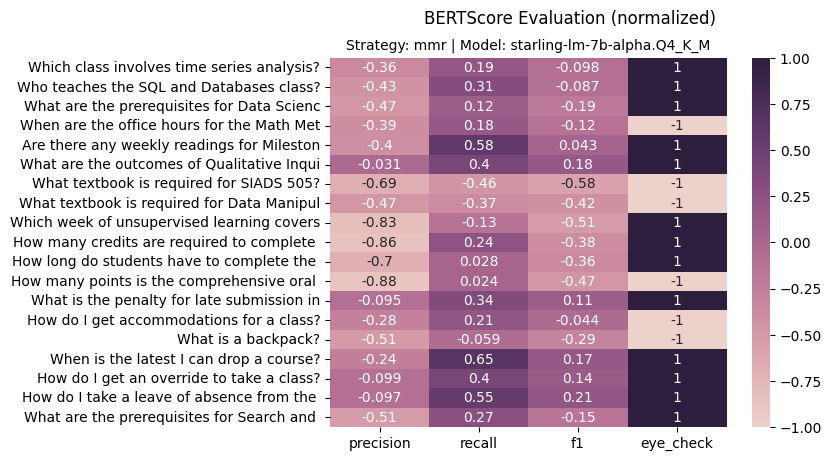

In [20]:
sns.heatmap(
    bert_df[["precision", "recall", "f1", "eye_check"]],
    yticklabels=bert_df["question"].str[:42],
    annot=True,
    cmap=sns.cubehelix_palette(as_cmap=True),
)

plt.suptitle("BERTScore Evaluation (normalized)")
plt.title(f"Strategy: {retrieval_strategy} | Model: {model}", fontsize=10)

plt.show()